### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import duckdb
import warnings
from prophet import Prophet
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from sklearn.metrics import mean_absolute_error

%matplotlib inline
warnings.filterwarnings('ignore')

c:\Users\rakes\miniconda3\envs\data_science_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


<!--  -->

### Sample Data

In [3]:
# Reproducibility
# np.random.seed(10)

# Data points
no_of_records = 71

# Datetime values
datetime_value = np.array("2024-01-01", dtype=np.datetime64)
datetime_values = datetime_value + np.arange(no_of_records)
# datetime_values = datetime_values.astype(str)
print(f"datetime_value_list --> {datetime_values}", "\n")

# # Timeseries values
# # values = np.random.randint(low=10, high=90, size=no_of_records)
# n_cycles=2

# # Generate time index
# time = np.arange(no_of_records)

# # Generate increasing and decreasing trends
# increasing_trend = np.clip(0.3 * time, 0, np.inf)
# decreasing_trend = np.clip(-0.3 * time, 0, np.inf)

# # Combine trends with seasonality and randomness
# data = (np.sin(2 * np.pi * time / no_of_records) * 2 + # Less Seasonal in each data point i.e., 2
#         0.3 * increasing_trend +
#         0.3 * decreasing_trend +
#         np.abs(np.random.normal(0, 8, no_of_records))) # More random in each data point i.e., 9
# data = [round(x, 2) for x in data]
data = [1.91, 4.12, 10.42, 5.49, 9.67, 8.64, 0.68, 0.38, 0.28, 0.18, 0.12, 
        11.77, 9.73, 5.4, 4.72, 5.84, 1.49, 
        0.37, 0.9, 1.62, 3.47, 2.78, 2.42, 1.85, 
        11.2, 7.13, 5.54, 8.78, 7.05, 0.86, 0.38, 0.28, 0.18, 0.12,
        0.1, 4.12, 10.42, 5.49, 4.67, 6.64, 0.68,
        0.37, 0.9, 1.62, 3.47, 2.78, 1.42, 
        1.91, 4.12, 10.42, 5.49, 9.67, 8.64, 0.68, 0.38, 0.28, 0.18, 0.12,
        11.77, 9.73, 5.4, 4.72, 5.84, 1.49, 
        0.37, 0.9, 1.62, 3.47, 2.78, 2.42, 1.85
        ]
print("Data count --> {0}, data --> {1}".format(len(data), data))

df = pd.DataFrame({"datetime":datetime_values, "value":data})
display(HTML(df.to_html()))

datetime_value_list --> ['2024-01-01' '2024-01-02' '2024-01-03' '2024-01-04' '2024-01-05'
 '2024-01-06' '2024-01-07' '2024-01-08' '2024-01-09' '2024-01-10'
 '2024-01-11' '2024-01-12' '2024-01-13' '2024-01-14' '2024-01-15'
 '2024-01-16' '2024-01-17' '2024-01-18' '2024-01-19' '2024-01-20'
 '2024-01-21' '2024-01-22' '2024-01-23' '2024-01-24' '2024-01-25'
 '2024-01-26' '2024-01-27' '2024-01-28' '2024-01-29' '2024-01-30'
 '2024-01-31' '2024-02-01' '2024-02-02' '2024-02-03' '2024-02-04'
 '2024-02-05' '2024-02-06' '2024-02-07' '2024-02-08' '2024-02-09'
 '2024-02-10' '2024-02-11' '2024-02-12' '2024-02-13' '2024-02-14'
 '2024-02-15' '2024-02-16' '2024-02-17' '2024-02-18' '2024-02-19'
 '2024-02-20' '2024-02-21' '2024-02-22' '2024-02-23' '2024-02-24'
 '2024-02-25' '2024-02-26' '2024-02-27' '2024-02-28' '2024-02-29'
 '2024-03-01' '2024-03-02' '2024-03-03' '2024-03-04' '2024-03-05'
 '2024-03-06' '2024-03-07' '2024-03-08' '2024-03-09' '2024-03-10'
 '2024-03-11'] 

Data count --> 71, data --> [1.91, 

,datetime,value
0,2024-01-01,1.91
1,2024-01-02,4.12
2,2024-01-03,10.42
3,2024-01-04,5.49
4,2024-01-05,9.67
5,2024-01-06,8.64
6,2024-01-07,0.68
7,2024-01-08,0.38
8,2024-01-09,0.28
9,2024-01-10,0.18


<!--  -->

### EDA

- Visualise Raw Timeseries 

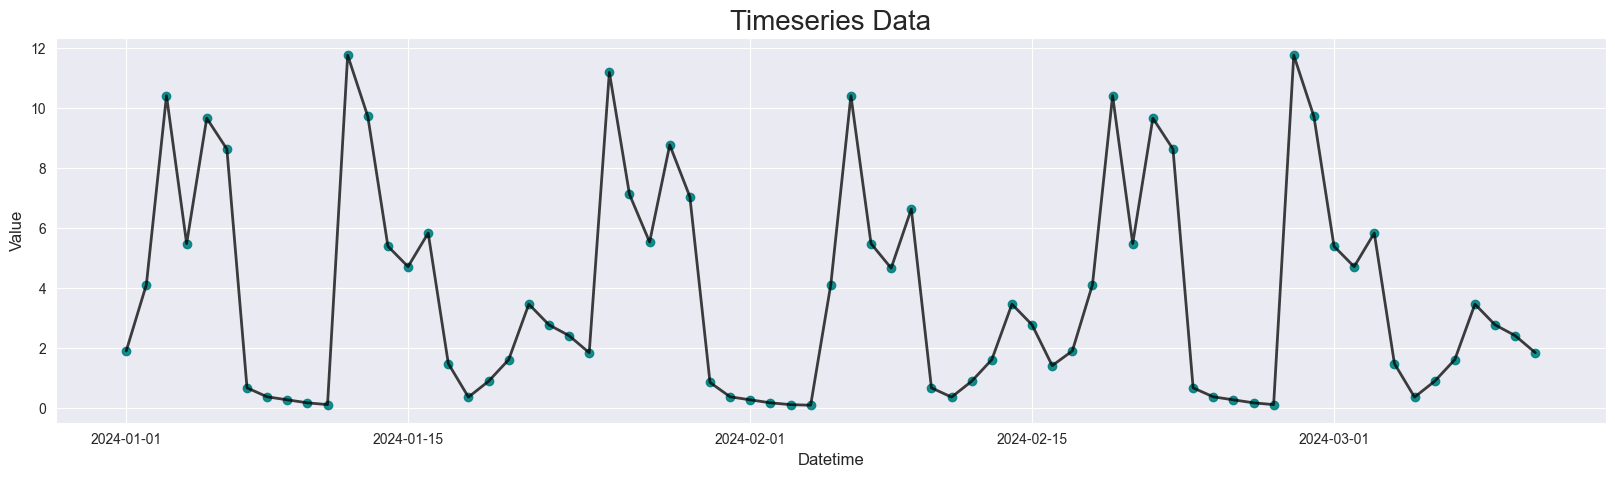

In [4]:
sns.set_style("dark")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5), sharex=True) # , dpi=100
axes.scatter(df.datetime, df.value, marker="o", color="teal", alpha=0.90)
# axes.plot(df.datetime, df.value, label="value", color="grey")
sns.lineplot(x="datetime", y="value", data=df, ax=axes, color='black', linewidth=2, alpha=0.75, label="")
plt.title("Timeseries Data", size=20)
plt.xlabel("Datetime", size=12)
plt.ylabel("Value", size=12)

plt.grid(True)
plt.show()

<!--  -->

### Data Preprocessing

- Timeseries Smoothing

In [5]:
df["value_smoothed_rw_2"] = df["value"].rolling(window=2).mean().tolist() # Moving Average (Rolling Window = 2)
df["value_smoothed_rw_3"] = df["value"].rolling(window=3).mean().tolist() # Moving Average (Rolling Window = 3)
df["value_smoothed_rw_4"] = df["value"].rolling(window=4).mean().tolist() # Moving Average (Rolling Window = 4)

cols = ["value_smoothed_rw_2", "value_smoothed_rw_3", "value_smoothed_rw_4"]
df[cols] = df[cols].apply(lambda x: round(x, 2)) # round to 2 decimals
display(HTML(df.head(5).to_html()))
display(HTML(df.tail(5).to_html()))

,datetime,value,value_smoothed_rw_2,value_smoothed_rw_3,value_smoothed_rw_4
0,2024-01-01,1.91,NaN,NaN,NaN
1,2024-01-02,4.12,3.02,NaN,NaN
2,2024-01-03,10.42,7.27,5.48,NaN
3,2024-01-04,5.49,7.96,6.68,5.48
4,2024-01-05,9.67,7.58,8.53,7.43


,datetime,value,value_smoothed_rw_2,value_smoothed_rw_3,value_smoothed_rw_4
66,2024-03-07,1.62,1.26,0.96,1.10
67,2024-03-08,3.47,2.55,2.00,1.59
68,2024-03-09,2.78,3.13,2.62,2.19
69,2024-03-10,2.42,2.60,2.89,2.57
70,2024-03-11,1.85,2.14,2.35,2.63


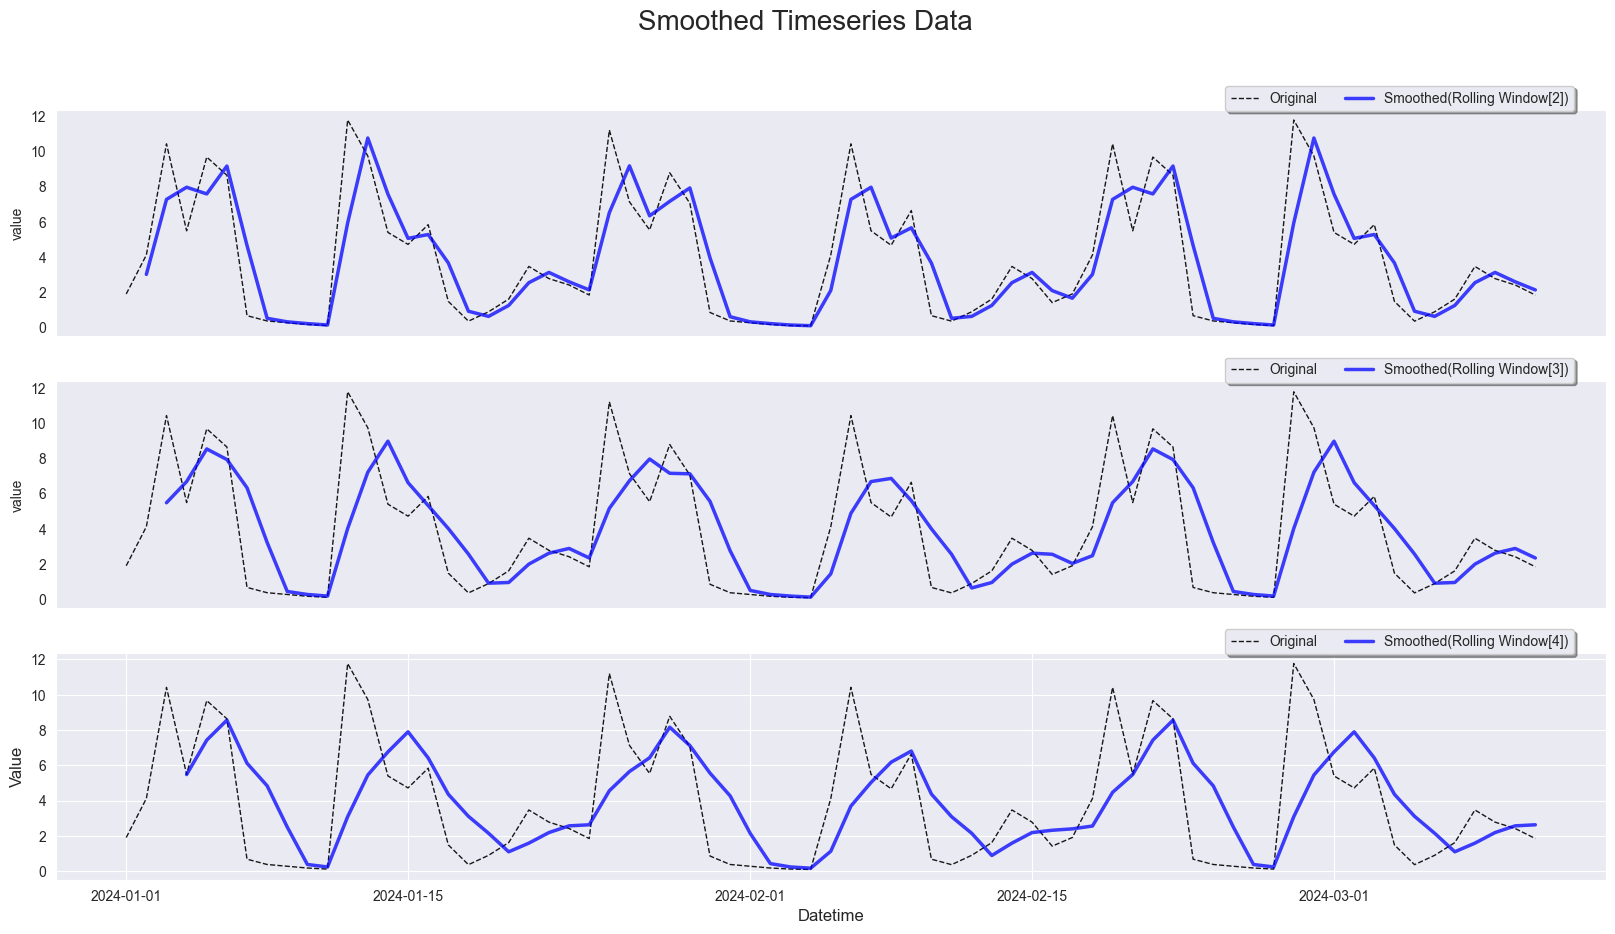

In [6]:
sns.set_style("dark")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True) # , dpi=100


for i in range(3):

    if i == 0:
        label = "Smoothed(Rolling Window[2])"
        col_val = "value_smoothed_rw_2"
    elif i == 1:
        label = "Smoothed(Rolling Window[3])"
        col_val = "value_smoothed_rw_3"
    else:
        label = "Smoothed(Rolling Window[4])"
        col_val = "value_smoothed_rw_4"
        
    s = sns.lineplot(x="datetime", y="value", data=df, ax=axes[i], color='black', linewidth=1, linestyle='--', alpha=0.9, label="Original")
    # s.set_linestyle("--")
    sns.lineplot(x="datetime", y=col_val, data=df, ax=axes[i], color='blue', linewidth=2.5, alpha=0.75, label=label)
    axes[i].legend(loc='center left', bbox_to_anchor=(.75, 1.05), fancybox=True, shadow=True, ncol=2, prop={'size':10})

plt.suptitle("Smoothed Timeseries Data", size=20)
plt.xlabel("Datetime", size=12)
plt.ylabel("Value", size=12)

plt.grid(True)
plt.show()

<!--  -->

### SQL Table Creation

- DB connection

In [70]:
conn = duckdb.connect(database=":memory:") # To make dataframe in memory table

In [71]:
# Table creation in DuckDB in memory DB
df.to_sql("data", conn)

-1

<!--  -->

### Train & Test Data Splits

- Choosing `Smoothed(Rolling Windoe[2])`

In [7]:
df_train = conn.execute("select * from data where datetime <= '2024-02-27'").fetchdf()

# Set the 'datetime' column as the index
# df_train = df_train.set_index('datetime')

# Maintaining Columns Structure
df_train = df_train[["datetime", "value_smoothed_rw_2"]]
df_train.columns = ["ds", "y"]

print("Train data shape: ", df_train.shape)
display(HTML(df_train.head(5).to_html()))
df_train.info()

NameError: name 'conn' is not defined

- Choosing `Smoothed(Rolling Window[2])`

In [73]:
df_test = conn.execute("select * from data where datetime > '2024-02-27'").fetchdf()

# Set the 'datetime' column as the index
# df_test = df_test.set_index('datetime')

# Maintaining Columns Structure
df_test = df_test[["datetime", "value_smoothed_rw_2"]]
df_test.columns = ["ds", "y"]

print("Test data shape: ", df_test.shape)
display(HTML(df_test.head(5).to_html()))
df_test.info()

Test data shape:  (13, 2)


,ds,y
0,2024-02-28,5.94
1,2024-02-29,10.75
2,2024-03-01,7.57
3,2024-03-02,5.06
4,2024-03-03,5.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      13 non-null     datetime64[us]
 1   y       13 non-null     float32       
dtypes: datetime64[us](1), float32(1)
memory usage: 288.0 bytes


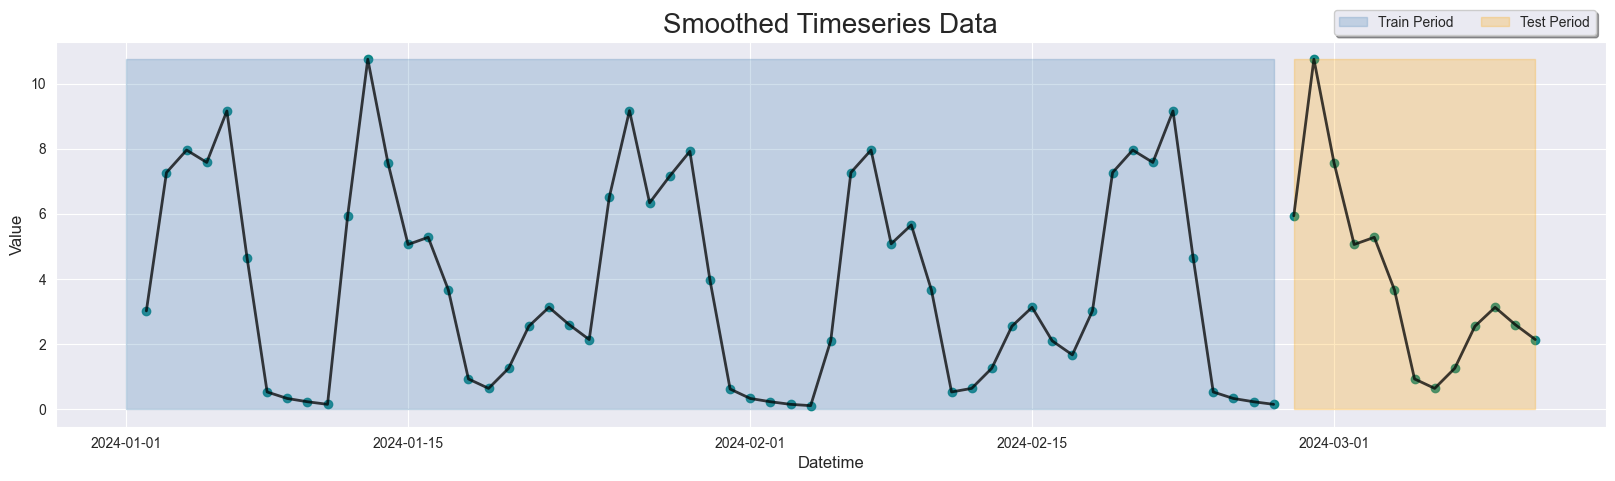

In [74]:
sns.set_style("dark")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5), sharex=True) # , dpi=100

axes.scatter(df_train.ds, df_train.y, marker="o", color="teal", alpha=0.90)
sns.lineplot(x=df_train.ds, y="y", data=df_train, ax=axes, color='black', linewidth=2, alpha=0.75, label="")
axes.fill_between(df_train.ds, [df_train.y.max() for x in range(len(df_train.y.tolist()))], color='steelblue', alpha=0.25, label="Train Period")

axes.scatter(df_test.ds, df_test.y, marker="o", color="teal", alpha=0.90)
sns.lineplot(x=df_test.ds, y="y", data=df_test, ax=axes, color='black', linewidth=2, alpha=0.75, label="")
# axes.axvline(datetime.strptime("2024-02-22", "%Y-%m-%d"), color='r', linestyle='dashed', linewidth=1)
axes.fill_between(df_test.ds, [df_train.y.max() for x in range(len(df_test.y.tolist()))], color='orange', alpha=0.25, label="Test Period")

plt.title("Smoothed Timeseries Data", size=20)
plt.xlabel("Datetime", size=12)
plt.ylabel("Value", size=12)

plt.legend(loc='center left', bbox_to_anchor=(.82, 1.05), fancybox=True, shadow=True, ncol=2, prop={'size':10})
plt.grid(True)
plt.show()

<!--  -->

### Model Fit

- Using Default Hyper parameters

21:22:09 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
0  2024-01-02  10.962711    6.930791   15.066650
1  2024-01-03   4.222071    0.525520    8.103515
2  2024-01-04   7.111098    3.014556   11.029629
3  2024-01-05  -6.254763   -9.995086   -2.285317
4  2024-01-06   1.026278   -3.000357    5.018896
..        ...        ...         ...         ...
65 2024-03-07   5.364289    1.441531    9.359827
66 2024-03-08  -8.001572  -12.121631   -4.072890
67 2024-03-09  -0.720531   -4.611383    3.462653
68 2024-03-10  -5.940571   -9.955732   -2.278684
69 2024-03-11  -2.586597   -6.427391    1.174073

[70 rows x 4 columns]


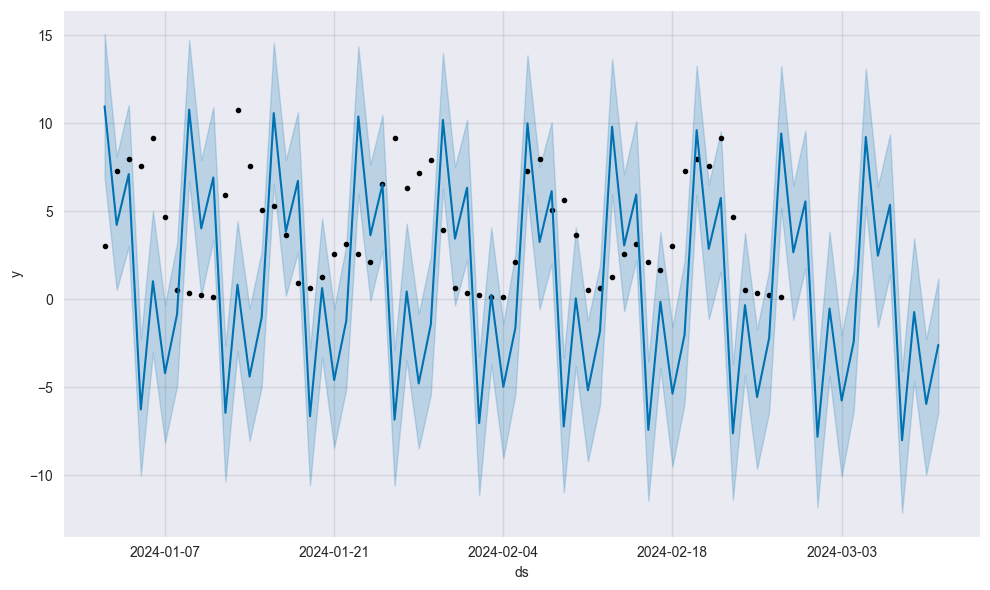

In [75]:
# Define the model
model = Prophet()

# Fit the model to the data
model.fit(df_train)

# Define the future dates for prediction (replace with desired forecast period)
future = model.make_future_dataframe(periods=len(df_test), freq='D')  # Forecast for the next 9 days

# Make predictions
forecast = model.predict(future)

# Print the forecast results (showing a glimpse)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize the forecast
model.plot(forecast)
plt.show()

Key points

- Prophet does not inherently restrict forecasts to non-negative values. However, you can enforce non-negative forecasts by applying a simple post-processing step after generating the predictions. This involves replacing any negative forecasted values with zero, like below

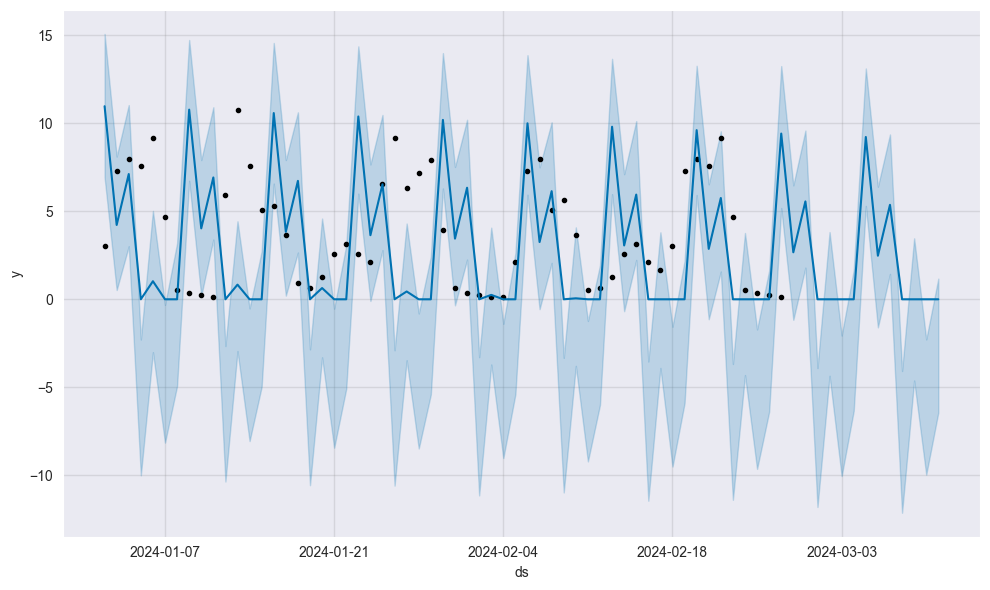

In [76]:
# Enforce non-negativity on forecasted values
forecast['yhat'] = np.maximum(forecast['yhat'], 0)

# Visualize the forecast
model.plot(forecast)
plt.show()

Observation

- Like above we can set lower bound of prediction to our static threshold i.e., 0. This might be important in few business cases where prediction can never go in negative values

In [77]:
# Forecast overview
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-02,1.802302,6.930791,15.066650,1.802302,1.802302,9.160409,9.160409,9.160409,9.160409,9.160409,9.160409,0.0,0.0,0.0,10.962711
1,2024-01-03,1.774575,0.525520,8.103515,1.774575,1.774575,2.447496,2.447496,2.447496,2.447496,2.447496,2.447496,0.0,0.0,0.0,4.222071
2,2024-01-04,1.746848,3.014556,11.029629,1.746848,1.746848,5.364250,5.364250,5.364250,5.364250,5.364250,5.364250,0.0,0.0,0.0,7.111098
3,2024-01-05,1.719121,-9.995086,-2.285317,1.719121,1.719121,-7.973884,-7.973884,-7.973884,-7.973884,-7.973884,-7.973884,0.0,0.0,0.0,0.000000
4,2024-01-06,1.691393,-3.000357,5.018896,1.691393,1.691393,-0.665115,-0.665115,-0.665115,-0.665115,-0.665115,-0.665115,0.0,0.0,0.0,1.026278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2024-03-07,0.000039,1.441531,9.359827,0.000039,0.000039,5.364250,5.364250,5.364250,5.364250,5.364250,5.364250,0.0,0.0,0.0,5.364289
66,2024-03-08,-0.027689,-12.121631,-4.072890,-0.027689,-0.027689,-7.973884,-7.973884,-7.973884,-7.973884,-7.973884,-7.973884,0.0,0.0,0.0,0.000000
67,2024-03-09,-0.055416,-4.611383,3.462653,-0.055416,-0.055416,-0.665115,-0.665115,-0.665115,-0.665115,-0.665115,-0.665115,0.0,0.0,0.0,0.000000
68,2024-03-10,-0.083143,-9.955732,-2.278684,-0.083143,-0.083143,-5.857428,-5.857428,-5.857428,-5.857428,-5.857428,-5.857428,0.0,0.0,0.0,0.000000


<!--  -->

<!--  -->

### Performance Evaluation
- Mean Absolute Error (MAE)
    - Measures the average absolute difference between actual and predicted values.
    - Lower values indicate better performance.
    - Advantages: Easy to interpret, robust to outliers.
    - Disadvantages: Ignores the direction of errors.
```text
MAE = 1/n ​∑(i=1->n)  ​∣y^​i ​− yi​∣
y^​i = prediction
yi = actual
|| = To make value as obsolute/postive
```

In [78]:
df_test.y

0      5.94
1     10.75
2      7.57
3      5.06
4      5.28
5      3.67
6      0.93
7      0.64
8      1.26
9      2.55
10     3.13
11     2.60
12     2.14
Name: y, dtype: float32

In [79]:
forecast.yhat.tolist()[-13:] # Get last 13 days predictions

[2.66935181391192,
 5.5583784892147765,
 0.0,
 0.0,
 0.0,
 0.0,
 9.215901445269207,
 2.475261907213823,
 5.364288582561468,
 0.0,
 0.0,
 0.0,
 0.0]

In [80]:
# Calculate evaluation metric
mae = mean_absolute_error(df_test.y, forecast.yhat.tolist()[-13:])
print(f"Mean Absolute Error: {round(mae,2)}")

Mean Absolute Error: 4.21


Observation

- On a average there is differnce of 4 units in actuals vs predictions, which is not so bad for this sample data. As Forecasting model found innternal pattern behaviour during training.
- When we provide data in higher volume, it finds more accurate pattern and can reduce this difference further more.

<!--  -->

### Model Fit

- With tweaked Hyper Parameters
    - `growth=logistic`
        - This parameter helps to make static upper threshold limit in forecast, by providing capacity (maximum possible value) for each observation in your dataset. This capacity can represent an upper limit or saturation level beyond which the growth of the time series variable is constrained.
        - Ex:- If Our forecast can't be > 25 

21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:25 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
0  2024-01-02  -5.898455   -9.661772   -2.120030
1  2024-01-03  10.747045    6.843948   14.891368
2  2024-01-04   5.097938    0.998182    9.284124
3  2024-01-05   1.765400   -2.164519    5.713753
4  2024-01-06   4.914896    0.961112    8.891767
..        ...        ...         ...         ...
65 2024-03-07   1.938350   -2.292071    5.541221
66 2024-03-08  -1.294866   -5.459300    2.455788
67 2024-03-09   1.951389   -1.824281    6.081894
68 2024-03-10  -1.712444   -5.533795    2.328453
69 2024-03-11   3.439621   -0.372927    7.309913

[70 rows x 4 columns]


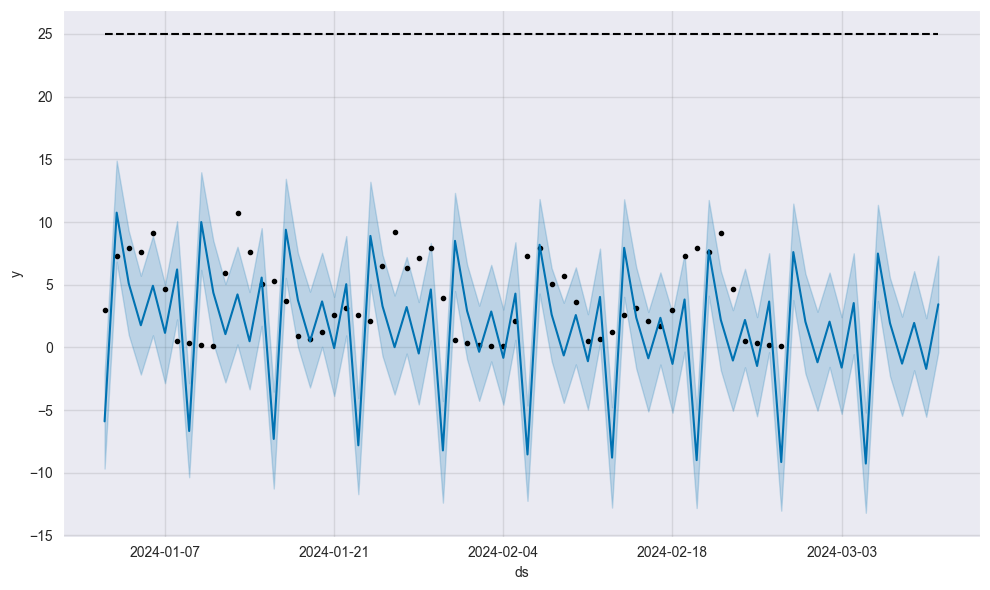

In [81]:
# Define the model
model = Prophet(growth='logistic')

# Fit the model to the data
df_temp = df_train.copy(deep=True)
df_temp["cap"] = 25
model.fit(df_temp)

# Define the future dates for prediction (replace with desired forecast period)
future = model.make_future_dataframe(periods=len(df_test), freq='D')  # Forecast for the next 9 days
future["cap"] = 25

# Make predictions
forecast = model.predict(future)

# Print the forecast results (showing a glimpse)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize the forecast
model.plot(forecast)
plt.show()

Observation

- In this time series as there is no logistic growth saturation ex:- reaching 25 and stays there continously like population growth rate. As this time series doesnt applicable for that, hence this parameter doesn't help much in forecasting 

<!--  -->

### Further Improvisation

Prophet model offers several hyperparameters that can be tuned to improve forecast quality and tailor the model to specific datasets. Here are some key hyperparameters you can adjust in Prophet:

```python
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    changepoint_prior_scale=0.5,
    holidays_prior_scale=20.0,
    holiday_seasonality='auto',
    growth='linear',
    mcmc_samples=300,
    uncertainty_samples=1000,
    daily_seasonality='auto'
)
```

1. **Seasonality Parameters:**
   - `seasonality_mode`: Determines the method used to model seasonality. Options include 'additive' (default), 'multiplicative', or 'auto'.
   - `seasonality_prior_scale`: Strength of the prior on the seasonality. Increasing this parameter makes the model more flexible and prone to overfitting to seasonal patterns.
   - `changepoint_prior_scale`: Strength of the prior on the changepoints. Higher values allow more flexibility in capturing abrupt changes in the time series.

2. **Holiday Parameters:**
   - `holidays_prior_scale`: Strength of the prior on holiday effects. Increasing this parameter allows the model to assign more weight to holiday-related fluctuations.
   - `holiday_seasonality`: Whether to include seasonality related to holidays. Can be set to 'auto', 'additive', or 'multiplicative'.

3. **Trend Parameters:**
   - `growth`: Growth trend specification. Options include 'linear', 'logistic' (requires specifying capacities), or 'flat'.
   - `changepoints`: List of dates at which to include potential changepoints in the trend.

4. **Model Uncertainty:**
   - `mcmc_samples`: Number of Markov Chain Monte Carlo (MCMC) samples used to estimate uncertainty intervals. Increasing this parameter improves the accuracy of uncertainty estimates but also increases computation time.
   - `uncertainty_samples`: Number of simulated draws used to estimate uncertainty intervals. Higher values lead to more accurate uncertainty estimates but also increase computation time.

5. **Additional Regressors:**
   - `add_regressor`: Allows the inclusion of additional regressors in the model, such as external predictors or covariates.

6. **Seasonality Parameters (for Daily Data):**
   - `daily_seasonality`: Whether to include daily seasonality. Can be set to 'auto', True, or False.

To improve forecast quality, you can experiment with adjusting these hyperparameters based on the characteristics of your dataset and the specific forecasting task. It's often beneficial to perform hyperparameter tuning using techniques such as ``grid search`` or ``random search`` to find the optimal combination of hyperparameters that maximizes forecast accuracy.

Adjust these hyperparameters based on your domain knowledge, the characteristics of your data, and the specific requirements of your forecasting task to achieve better forecast performance.